### Input: 
Arrest data was exported on April 10th, 2024, with the lates update of the data on January 18, 2024.\
https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc/about_data

### Note:
In this file, it can be used to explain why our focus in in Brooklyn, and the data is solely in 2023.

### Need to Check:
1. null values in merged data
2. within vs. intersects
3. read 2263 from .prj files
4. default 4326, ctx 3857

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from shapely.wkt import loads
import calendar
import warnings
warnings.filterwarnings('ignore')

In [2]:
arrest = pd.read_csv('../../data/raw/NYPD_Arrest_Data__Year_to_Date__20240410.csv'); arrest.head(3)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,261265483,01/03/2023,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1600500,F,B,49,0,18-24,M,BLACK,1027430,251104,40.855793,-73.843908,POINT (-73.843908 40.855793)
1,261271301,01/03/2023,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,S,120,0,25-44,M,WHITE,962808,174275,40.644996,-74.077263,POINT (-74.077263 40.644996)
2,261336449,01/04/2023,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601001,F,K,61,0,<18,M,BLACK,995118,155708,40.594054,-73.960866,POINT (-73.960866 40.594054)


## Preprocessing

In [3]:
print(arrest.columns)
arrest = arrest[['ARREST_KEY', 'ARREST_DATE', 'OFNS_DESC', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column']]

Index(['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC',
       'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column'],
      dtype='object')


### Sanity Check

In [4]:
# check if the unqiue values of ARREST_BORO are corresponding to 5 boroughs: K represents Brooklyn based on the data dictionary
print(arrest.ARREST_BORO.unique())

['B' 'S' 'K' 'Q' 'M']


The shape of original data is: (226872, 15)



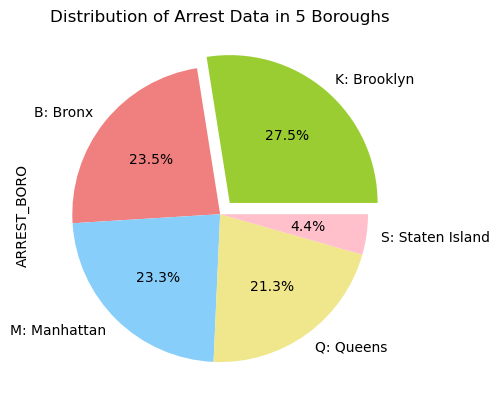


The shape of Brooklyn data is: (62395, 15), which is around 27.5% of original data


In [5]:
print('The shape of original data is:', arrest.shape)
print()
# Plotting the pie chart
plt.figure()
labels = ['K: Brooklyn', 'B: Bronx', 'M: Manhattan', 'Q: Queens', 'S: Staten Island']
colors = ['yellowgreen', 'lightcoral', 'lightskyblue', 'khaki', 'pink']
explode = (0.1, 0, 0, 0, 0)  
arrest['ARREST_BORO'].value_counts().plot(kind='pie', autopct='%1.1f%%', explode=explode, colors=colors, labels=labels)
plt.title('Distribution of Arrest Data in 5 Boroughs')

plt.savefig('../../results/crime_boroughs.png')
plt.show()
print()

arrest_bk = arrest[arrest.ARREST_BORO == 'K']
print(f'The shape of Brooklyn data is: {arrest_bk.shape}, which is around {round(100*(arrest_bk.shape[0]/arrest.shape[0]), 2)}% of original data')

In [6]:
# filter out those with either OFNS_DESC or LAW_CAT_CD are equal to '(null)'
if len(arrest_bk[((arrest_bk.OFNS_DESC == '(null)') | (arrest_bk.LAW_CAT_CD == '(null)'))]) > 0:
    arrest_bk = arrest_bk[~((arrest_bk.OFNS_DESC == '(null)') | (arrest_bk.LAW_CAT_CD == '(null)'))]
    print('After fileter out those with either OFNS_DESC or LAW_CAT_CD equal to \'(null)\', the shape is:', arrest_bk.shape)
else:
    print('No \"either OFNS_DESC or LAW_CAT_CD equal\"" found!')
# filter out those with both OFNS_DESC and LAW_CAT_CD be null values
if len(arrest_bk[((arrest_bk.OFNS_DESC.isnull()) & (arrest_bk.LAW_CAT_CD.isnull()))]):
    arrest_bk = arrest_bk[~((arrest_bk.OFNS_DESC.isnull()) & (arrest_bk.LAW_CAT_CD.isnull()))]
    print('After fileter out those with both OFNS_DESC and LAW_CAT_CD be null values, the shape is:', arrest_bk.shape)
else:
    print('No \"OFNS_DESC being null and LAW_CAT_CD being null simultaneously\" found!')
# filter out those with either OFNS_DESC or LAW_CAT_CD be null values
if len(arrest_bk[((arrest_bk.OFNS_DESC.isnull()) | (arrest_bk.LAW_CAT_CD.isnull()))]):
    arrest_bk = arrest_bk[~((arrest_bk.OFNS_DESC.isnull()) | (arrest_bk.LAW_CAT_CD.isnull()))]
    print('After fileter out those with either OFNS_DESC or LAW_CAT_CD be null values, the shape is:', arrest_bk.shape)
else:
    print('No \"OFNS_DESC being null and LAW_CAT_CD being null simultaneously\" found!')
# filter out those LAW_CAT_CD == '9'
if len(arrest_bk[arrest_bk.LAW_CAT_CD == '9']) > 0:
    arrest_bk = arrest_bk[arrest_bk.LAW_CAT_CD != '9']
    print('After fileter out those LAW_CAT_CD == \'9\', the shape is:', arrest_bk.shape)
else:
    print('No LAW_CAT_CD == \'9\' found!')

# combining V and I into one category V/I in column LAW_CAT_CD
arrest_bk['LAW_CAT_CD'] = arrest_bk['LAW_CAT_CD'].replace({'V': 'V/I', 'I': 'V/I'})

After fileter out those with either OFNS_DESC or LAW_CAT_CD equal to '(null)', the shape is: (62390, 15)
No "OFNS_DESC being null and LAW_CAT_CD being null simultaneously" found!
After fileter out those with either OFNS_DESC or LAW_CAT_CD be null values, the shape is: (62190, 15)
After fileter out those LAW_CAT_CD == '9', the shape is: (62178, 15)


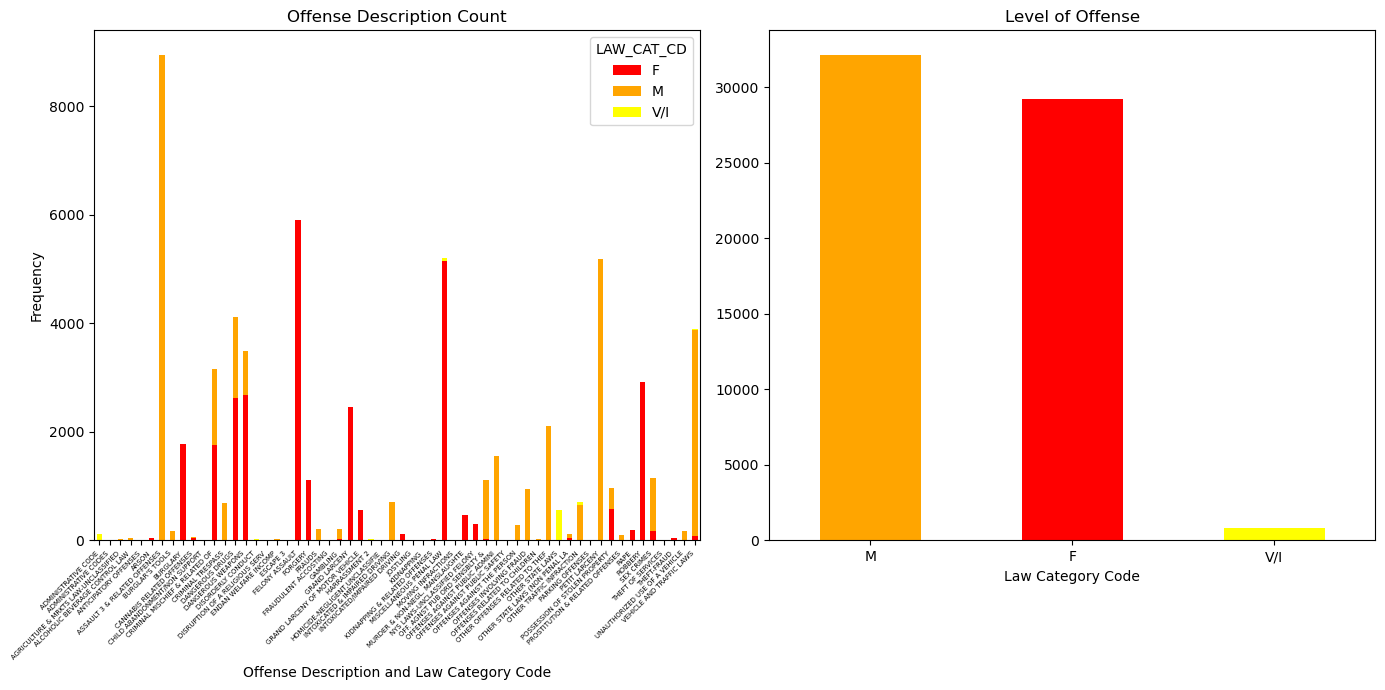

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

grouped = arrest_bk.groupby(['OFNS_DESC','LAW_CAT_CD']).size().sort_values(ascending=False).unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, color=['r','orange','yellow'], ax=axes[0])
axes[0].set_title('Offense Description Count')
axes[0].set_xlabel('Offense Description and Law Category Code')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', which='major', labelsize=5)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

arrest_bk['LAW_CAT_CD'].value_counts().plot(kind='bar', color=['orange','r','yellow'], ax=axes[1])
axes[1].set_title('Level of Offense')
axes[1].set_xlabel('Law Category Code')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()

plt.show()

In order to save the figure:

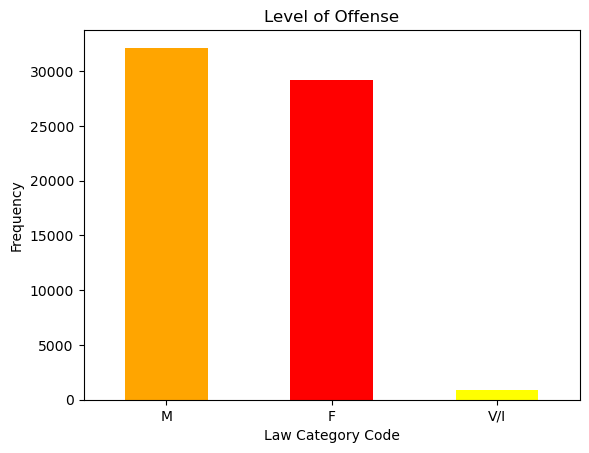

In [8]:
arrest_bk['LAW_CAT_CD'].value_counts().plot(kind='bar', color=['orange', 'red', 'yellow'])

plt.title('Level of Offense')
plt.xlabel('Law Category Code')
plt.ylabel('Frequency')

plt.xticks(rotation=0)

plt.savefig('../../results/level_of_offense.png', bbox_inches='tight')

plt.show()

In [9]:
arrest['ARREST_DATE'] = pd.to_datetime(arrest['ARREST_DATE'])
arrest['ARREST_DATE'].dt.year.unique()

array([2023], dtype=int64)

In [10]:
arrest_bk['ARREST_DATE'] = pd.to_datetime(arrest_bk['ARREST_DATE'])

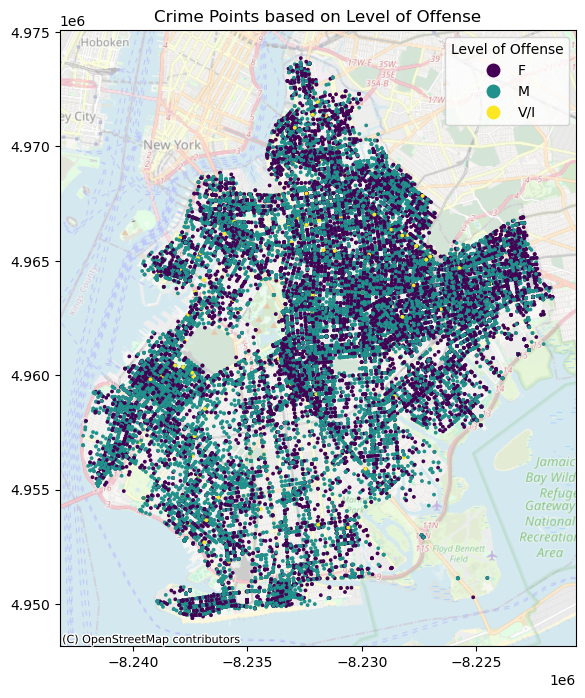

In [11]:
gdf = gpd.GeoDataFrame(arrest_bk, geometry=gpd.points_from_xy(arrest_bk['Longitude'], arrest_bk['Latitude']))

gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857) # in order to match the base map

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, column='LAW_CAT_CD', legend=True, markersize=3, categorical=True, cmap='viridis', legend_kwds={'title': 'Level of Offense'})
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

plt.title('Crime Points based on Level of Offense')
plt.savefig('../../results/level_of_offense_map.png')
plt.show()

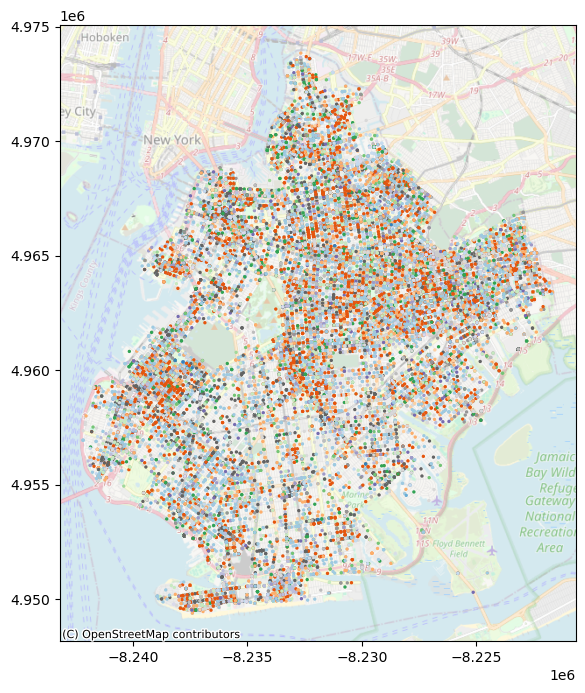

In [12]:
gdf = gpd.GeoDataFrame(arrest_bk, geometry=gpd.points_from_xy(arrest_bk['Longitude'], arrest_bk['Latitude']))

gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857) # in order to match the base map

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, column='OFNS_DESC', legend=False, markersize=2, categorical=True, cmap='tab20c', legend_kwds={'title': 'Description of Internal Classification'})
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

plt.show()

## Merge with Zipcode and Do Statistics

In [13]:
zipcode = gpd.read_file("../../data/processed_data/zipcode_bk.shp"); zipcode.head(3)

,ZIPCODE,PO_NAME,POPULATION,AREA,ST_FIPS,CTY_FIPS,geometry
0,11213,Brooklyn,62426.0,2.963100e+07,36,047,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
1,11212,Brooklyn,83866.0,4.197210e+07,36,047,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
2,11225,Brooklyn,56527.0,2.369863e+07,36,047,"POLYGON ((995908.365 183617.613, 996522.848 18..."


In [14]:
zipcode_gdf = gpd.GeoDataFrame(zipcode, geometry=zipcode['geometry'], crs="EPSG:2263") # this is recorded in .prj file
gdf = gdf.to_crs(epsg=2263)
arrest_zipcode = gpd.sjoin(gdf, zipcode_gdf, how="left", op='intersects')
arrest_zipcode.head(3)

,ARREST_KEY,ARREST_DATE,OFNS_DESC,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,...,Longitude,New Georeferenced Column,geometry,index_right,ZIPCODE,PO_NAME,POPULATION,AREA,ST_FIPS,CTY_FIPS
2,261336449,2023-01-04,ROBBERY,F,K,61,0,<18,M,BLACK,...,-73.960866,POINT (-73.960866 40.594054),POINT (995118.352 155708.729),32.0,11223.0,Brooklyn,79864.0,5.870292e+07,36,047
5,261583093,2023-01-08,FELONY ASSAULT,F,K,76,0,25-44,M,BLACK,...,-74.000504,POINT (-74.000504 40.683691),POINT (984110.216 188363.492),19.0,11231.0,Brooklyn,33144.0,3.937969e+07,36,047
7,261892107,2023-01-14,FELONY ASSAULT,F,K,90,0,25-44,M,BLACK,...,-73.955662,POINT (-73.955662 40.714082),POINT (996541.480 199438.946),38.0,11211.0,Brooklyn,60861.0,4.047088e+07,36,047


<Axes: >

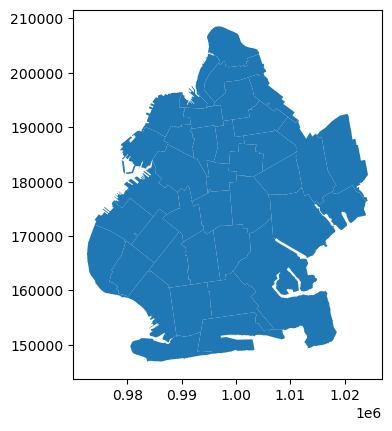

In [15]:
zipcode_gdf.plot()

In [16]:
zipcode_gdf.isnull().sum()

ZIPCODE       0
PO_NAME       0
POPULATION    0
AREA          0
ST_FIPS       0
CTY_FIPS      0
geometry      0
dtype: int64

In [17]:
crime_zipcode = arrest_zipcode.groupby('ZIPCODE').size().reset_index(name='counts')

In [18]:
combined_data = crime_zipcode.merge(zipcode, left_on='ZIPCODE', right_on='ZIPCODE', how ='outer')[['ZIPCODE', 'counts', 'geometry']]

In [19]:
gdf = gpd.GeoDataFrame(combined_data, geometry='geometry')

In [20]:
gdf = gdf.drop(29)

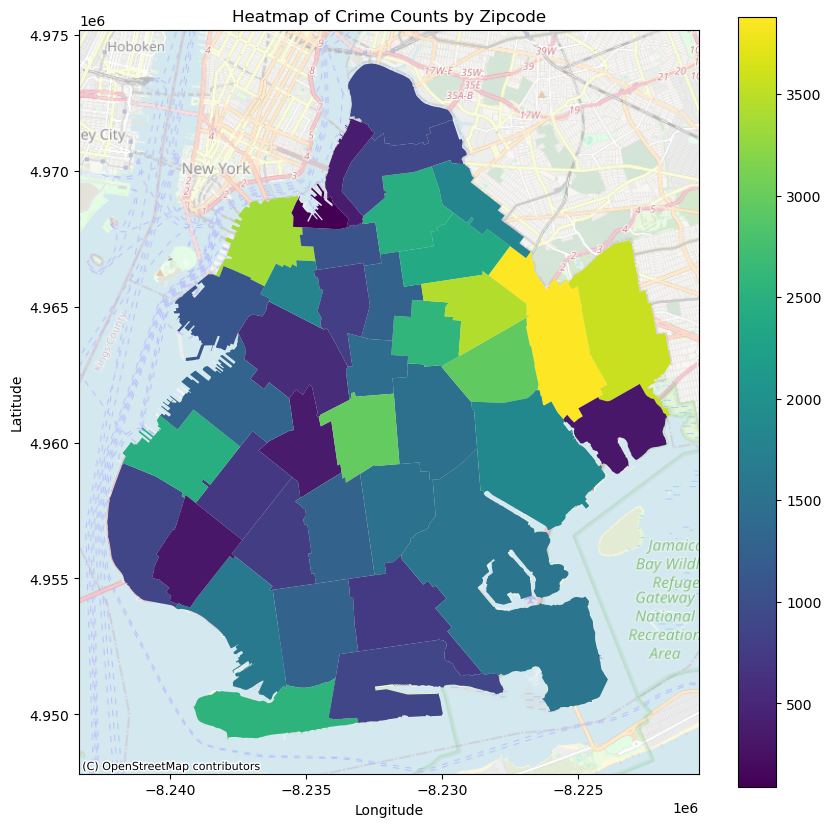

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf = gdf.to_crs(epsg=3857)

gdf.plot(column='counts', cmap='viridis', linewidth=0.8, ax=ax, legend=True)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

ax.set_title('Heatmap of Crime Counts by Zipcode')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('../../results/heatmap_crime.png')
plt.show()

In [22]:
gdf = gdf.to_crs(epsg=2263)

gdf['area_sq_mi'] = gdf['geometry'].area * 0.000000386102

gdf['density'] = gdf['counts'] / gdf['area_sq_mi']

gdf = gdf.to_crs(epsg=3857)

In [23]:
gdf

,ZIPCODE,counts,geometry,area_sq_mi,density
0,11201.0,3348,"POLYGON ((-8235269.856 4968992.104, -8235280.4...",15.866818,211.006390
1,11203.0,1476,"POLYGON ((-8231263.298 4962915.398, -8231132.9...",23.415092,63.036267
2,11204.0,770,"POLYGON ((-8235536.585 4958694.926, -8235521.9...",16.816744,45.787698
3,11205.0,1067,"POLYGON ((-8232449.560 4968095.580, -8232401.8...",8.984651,118.758092
4,11206.0,2463,"POLYGON ((-8230118.726 4969362.977, -8230107.4...",15.714630,156.732933
5,11207.0,3881,"POLYGON ((-8226920.124 4966791.319, -8226910.7...",28.558521,135.896391
6,11208.0,3561,"POLYGON ((-8222760.815 4965748.453, -8222758.3...",30.619311,116.299156
7,11209.0,876,"POLYGON ((-8241753.575 4959199.676, -8241746.2...",22.333033,39.224408
8,11210.0,1511,"POLYGON ((-8233011.383 4958847.012, -8232903.8...",18.489275,81.723052
9,11211.0,891,"POLYGON ((-8229426.088 4971328.556, -8229362.6...",15.625888,57.020758


In [24]:
gdf['density']

0     211.006390
1      63.036267
2      45.787698
3     118.758092
4     156.732933
5     135.896391
6     116.299156
7      39.224408
8      81.723052
9      57.020758
10    182.715595
11    224.463947
12     68.589850
13     23.380781
14    124.030434
15    215.711215
16     25.851561
17     43.780296
18    134.974334
19    159.438774
20     55.760739
21     55.635668
22    140.918265
23    155.954771
24    195.389793
25     18.646165
26     31.405909
27     66.764193
28     72.872790
30     59.884073
31    235.461682
32     19.657190
33     33.156037
34     50.174427
35    171.401328
36     68.821313
37     19.830201
38     57.418630
39     22.750353
Name: density, dtype: float64

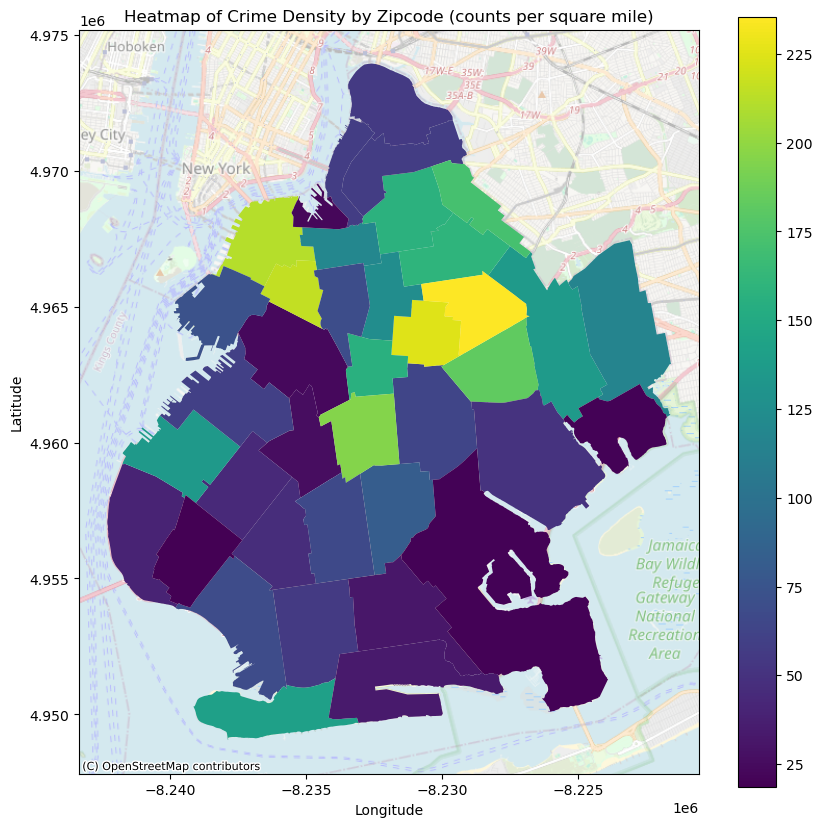

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf.plot(column='density', cmap='viridis', linewidth=0.8, ax=ax, legend=True)


ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

ax.set_title('Heatmap of Crime Density by Zipcode (counts per square mile)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#ax.set_xticks([])
#ax.set_yticks([])

plt.savefig('../../results/heatmap_crime_density.png')

plt.show()

In [26]:
null_counts = arrest_zipcode.isnull().sum()
print(null_counts)

ARREST_KEY                    0
ARREST_DATE                   0
OFNS_DESC                     0
LAW_CAT_CD                    0
ARREST_BORO                   0
ARREST_PRECINCT               0
JURISDICTION_CODE             0
AGE_GROUP                     0
PERP_SEX                      0
PERP_RACE                     0
X_COORD_CD                    0
Y_COORD_CD                    0
Latitude                      0
Longitude                     0
New Georeferenced Column      0
geometry                      0
index_right                 665
ZIPCODE                     665
PO_NAME                     665
POPULATION                  665
AREA                        665
ST_FIPS                     665
CTY_FIPS                    665
dtype: int64


In [27]:
arrest_zipcode = arrest_zipcode[~arrest_zipcode.isnull().any(axis=1)]

In [28]:
column_chosen = []
for col in list(arrest_zipcode.columns):
    if len(arrest_zipcode[col].unique()) == 1:
        column_chosen.append(col)
        print(f'There is only 1 unique value in column {col}, which is {arrest_zipcode[col].unique()}')

There is only 1 unique value in column ARREST_BORO, which is ['K']
There is only 1 unique value in column PO_NAME, which is ['Brooklyn']
There is only 1 unique value in column ST_FIPS, which is ['36']
There is only 1 unique value in column CTY_FIPS, which is ['047']


In [29]:
arrest_zipcode = arrest_zipcode.drop('ARREST_BORO', axis=1)

### Calculate the Statisitcs

In [30]:
arrest_zipcode.head(3)

,ARREST_KEY,ARREST_DATE,OFNS_DESC,LAW_CAT_CD,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,...,Longitude,New Georeferenced Column,geometry,index_right,ZIPCODE,PO_NAME,POPULATION,AREA,ST_FIPS,CTY_FIPS
2,261336449,2023-01-04,ROBBERY,F,61,0,<18,M,BLACK,995118,...,-73.960866,POINT (-73.960866 40.594054),POINT (995118.352 155708.729),32.0,11223.0,Brooklyn,79864.0,5.870292e+07,36,047
5,261583093,2023-01-08,FELONY ASSAULT,F,76,0,25-44,M,BLACK,984110,...,-74.000504,POINT (-74.000504 40.683691),POINT (984110.216 188363.492),19.0,11231.0,Brooklyn,33144.0,3.937969e+07,36,047
7,261892107,2023-01-14,FELONY ASSAULT,F,90,0,25-44,M,BLACK,996541,...,-73.955662,POINT (-73.955662 40.714082),POINT (996541.480 199438.946),38.0,11211.0,Brooklyn,60861.0,4.047088e+07,36,047


In [31]:
arrest_zipcode['month'] = arrest_zipcode['ARREST_DATE'].dt.month

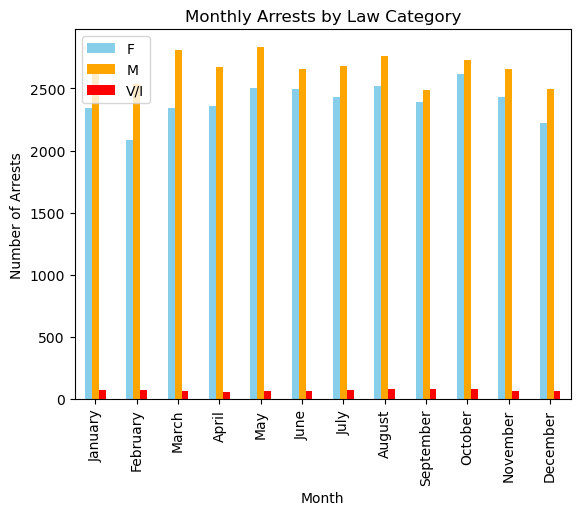

In [33]:
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
arrest_zipcode['month_name'] = arrest_zipcode['month'].map(month_names)

arrest_zipcode['month_name'] = pd.Categorical(arrest_zipcode['month_name'],
                                              categories=[month_names[i] for i in sorted(month_names)],
                                              ordered=True)

data_to_plot = arrest_zipcode.groupby(['month_name', 'LAW_CAT_CD']).size().unstack()

ax = data_to_plot.plot(kind='bar', color=['skyblue', 'orange', 'red'])


ax.set_title('Monthly Arrests by Law Category')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Arrests')
plt.xticks(rotation=90)
ax.legend(loc='best')

plt.savefig("../../results/monthly_arrest_by_law_cat.png")

plt.show()

In [34]:
arrest_zipcode.columns

Index(['ARREST_KEY', 'ARREST_DATE', 'OFNS_DESC', 'LAW_CAT_CD',
       'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX',
       'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'New Georeferenced Column', 'geometry', 'index_right', 'ZIPCODE',
       'PO_NAME', 'POPULATION', 'AREA', 'ST_FIPS', 'CTY_FIPS', 'month',
       'month_name'],
      dtype='object')

In [35]:
arrest_zipcode['ZIPCODE'] = arrest_zipcode['ZIPCODE'].astype(int)

In [36]:
pd.crosstab(arrest_zipcode['ZIPCODE'], arrest_zipcode['month']).sum().sum()

61563

In [37]:
monthlyArrestCounts = pd.crosstab(arrest_zipcode['ZIPCODE'], arrest_zipcode['month'])
# rename the columns
monthlyArrestCounts.columns = [calendar.month_abbr[month] for month in monthlyArrestCounts.columns]
monthlyArrestCounts.columns = [f'{month}_ArrestCounts' for month in monthlyArrestCounts.columns]

In [38]:
summary = arrest_zipcode.groupby('ZIPCODE').agg(
    ArrestCount=pd.NamedAgg(column='ARREST_KEY', aggfunc='size'),
    population=pd.NamedAgg(column='POPULATION', aggfunc='mean'), 
    geometry=pd.NamedAgg(column='geometry', aggfunc='first')
)

summary = summary.join(monthlyArrestCounts, on='ZIPCODE')

In [ ]:
summary.columns

In [ ]:
#summary.to_csv("../../data/processed_data/arrest_statistics.csv")

In [ ]:
summary

In [ ]:
summary.shape